In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [3]:
experiment = 'blobs'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
#### Responsive params
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(dst_dir)

ROC 0.05
traces001|dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning


# Load data

In [4]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [5]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1252 |
| Lm |          1035 |
| Li |           577 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            15 |


In [6]:
counts = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       577 |
| Lm            |      1035 |
| V1            |      1252 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       397 |        13 |
| Lm            |       643 |        10 |
| V1            |      1031 |         9 |


In [7]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA['datakey'].unique(), experiment='blobs',
                        images_only=False, rename=True,
                        return_incorrect=True, return_all=False)

In [8]:
incorrect_stim.keys()

dict_keys(['20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1'])

In [388]:
response_type='dff'
do_spherical_correction=False
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


# Tuning curves

In [10]:
import analyze2p.objects.selectivity as sel

In [245]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [564]:
va='V1'
dk='20190616_JC097_fov1'
offset_type='minsub' 
lcorrection='exclude'
with_lum = False

sdf = aggr.get_stimuli(dk, experiment, match_names=True)
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
print(morphlevels)

x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) & (NDATA0.config.isin(configs))].copy()
rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
rdf.head()

[0, 14, 27, 40, 53, 66, 79, 92, 106]


,cell,config,response,size,morphlevel
0,0,config006,0.073549,10.0,0
1,0,config007,0.062874,20.0,0
2,0,config008,0.089596,30.0,0
3,0,config009,0.102889,40.0,0
4,0,config010,0.181599,50.0,0


In [565]:
ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf)
ixs_['visual_area'] = va
ixs_['datakey'] = dk


In [566]:
#### Generate morph tuning curves
# morph_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y, 
#                 x='morphlevel', y='size', normalize=True).reset_index(drop=True)
# morph_mat = morph_curves[['cell', 'response', 'morphlevel']]\
#                 .pivot(columns='cell', index='morphlevel')
# print(morph_curves['size'].unique())

# #### Generate size tuning curves
# size_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y, 
#                                            x='size', y='morphlevel', normalize=True).reset_index(drop=True)
# size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

morph_mat, size_mat = sel.get_object_tuning_curves(rdf, sort_best_size=True,
                                                  normalize=True)

#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, 
                                        at_best_other=True, name='morph_sel')
morph_ixs.index = morph_ixs.index.droplevel(1)
sorted_morph_ixs = morph_ixs.sort_values(by='morph_sel', ascending=False)
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, 
                                        at_best_other=True, name='size_tol')
size_tols.index = size_tols.index.droplevel(1)
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

#### Aggregate
best_ixs = pd.concat([size_tols, morph_ixs], axis=1).reset_index()
best_ixs.index=best_ixs['cell']
best_ixs.head()

,cell,size_tol,best_morphlevel,morph_sel,best_size
cell,,,,,
0,0,0.452792,0.0,0.605266,50.0
1,1,0.447143,53.0,0.175861,50.0
2,2,0.421139,53.0,0.515437,50.0
9,9,0.362837,14.0,0.360534,20.0
11,11,0.381669,79.0,0.319997,10.0


In [567]:
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['cornflowerblue',  'orange'] #, 'k']
roi_styles = ['-', '-']
size_labels = [int(s) for s in sorted(sdf['size'].unique())]
morph_labels = [int(s) for s in sorted(sdf['morphlevel'].unique())]
rank_order=False

# V1: 20190616_JC097_fov1
# -----------------------
if va=='V1' and dk=='20190616_JC097_fov1':
    rois_plot_mp = [217, 388] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
    #rois_plot_sz = [405, 388] #405#[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()
    rois_plot_sz = [217, 388]
    cmaps=['cool', 'cool_r']
elif va=='Lm' and dk=='20190504_JC078_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    rois_plot_mp = [194, 185] #24]
    # rois_plot_sz = [294, 76] 
    rois_plot_sz = [194, 185]
    cmaps=['cool', 'cool_r']
    
elif va=='Li' and dk=='20190422_JC076_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    rois_plot_sz = [119, 76] 
    #rois_plot_sz = [293, 76] 
    rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']

elif va=='Li' and dk=='20190614_JC091_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    rois_plot_sz = [304, 234] #[331, 234] 
    rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']
lw=0.25

<IPython.core.display.Javascript object>


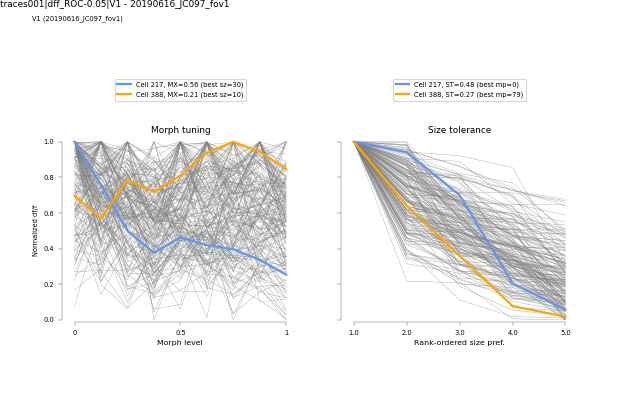

In [568]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(8,5), sharey=True)
ax=axn[0]
rank_order=False
if rank_order:
    xx = morph_mat.copy()
    xx.values.sort(axis=0)
    mm = xx[::-1]
else:
    mm = morph_mat.copy()
ax.plot(mm.values, color='gray', alpha=1, lw=lw)
ax.set_title("Morph tuning")
for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(mm[rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, MX=%.2f (best sz=%i)' 
            % (rid, best_ixs.loc[rid]['morph_sel'], best_sz))
xlabel = 'Rank-ordered morphs' if rank_order else 'Morph level' 
xtick_ixs = np.linspace(0, len(morph_labels)-2, 3, endpoint=True)
ax.set_xticks(xtick_ixs)
xticks = xtick_ixs+1 if rank_order else [0, 0.5, 1]
ax.set_xticklabels(xticks)
ax.set_xlabel(xlabel, fontsize=7)
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)
ax.set_ylim([0, 1])
# --------------------------------------------------------------
# Size Tolerance
# --------------------------------------------------------------
ax=axn[1]
rank_order=True
if rank_order:
    xx = size_mat.copy()
    xx.values.sort(axis=0) #[::-1]
    sz = xx[::-1]
else:
    sz = size_mat.copy()
    
ax.plot(sz.values, color='gray', alpha=1, lw=lw)
ax.set_title("Size tolerance")

for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())
    ax.plot(sz[rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, ST=%.2f (best mp=%i)'
            % (rid, best_ixs.loc[rid]['size_tol'], best_mp))
xlabel = 'Rank-ordered size pref.' if rank_order else 'Size (deg)'
xticks = np.arange(0, len(size_labels)) if rank_order else size_labels
xtick_labels = np.linspace(1, len(size_labels), len(size_labels))\
                    if rank_order else size_labels
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel(xlabel, fontsize=7)
ax.set_ylim([0, 1.01])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)

sns.despine(offset=2, trim=True)
axn[0].set_ylabel('Normalized df/f')
fig.text(0.05, 0.95, '%s (%s)' % (va, dk), fontsize=6)

pplot.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.9, top=0.65, bottom=0.2)

In [259]:
from scipy import signal

In [275]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [575]:
%matplotlib notebook
r1 =217
r2=388
# r1 =0
# r2= 65

stim_param = 'size'
morph_mat, size_mat = sel.get_object_tuning_curves(rdf_sub, 
                                        sort_best_size=True, normalize=True)
val_mat = morph_mat.copy() if stim_param=='morph' else size_mat.copy()
    
curve1 = val_mat[r1].values
curve2 = val_mat[r2].values

levels = val_mat[r2].index.to_numpy() #.values
levels

array([1., 2., 3., 4., 5.])

<IPython.core.display.Javascript object>


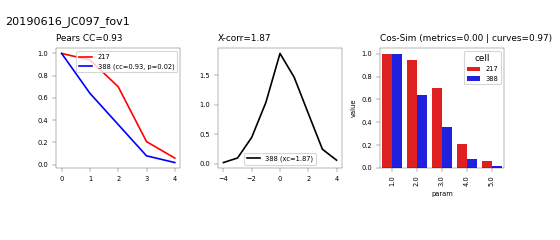

Text(0.01, 0.9, '20190616_JC097_fov1')

In [576]:
# r2 = 116
#r2 = 281
c1='r'
c2='b'
roi_colors={r1: c1, r2: c2}

fig, axn = pl.subplots(1,3, figsize=(7,3))
ax=axn[0]
ax.plot(curve1, label=r1, color=c1)
cc, pv = spstats.pearsonr(curve1, curve2)
axn[0].plot(curve2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv), color=c2)
axn[0].set_title('Pears CC=%.2f' % cc, loc='left', fontsize=8)
axn[0].legend()

ccorr = signal.correlate(curve1, curve2)
lags = signal.correlation_lags(len(curve1), len(curve1))

#ax.legend()
lagzero = list(lags).index(0)
xcorr = ccorr[lagzero]
axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr), color='k')
axn[1].set_title('X-corr=%.2f' % xcorr, loc='left', fontsize=8)
axn[1].legend()
# --------------------------------------
ax=axn[2]
cosim_c = cr.cosine_similarity(curve1, curve2)
# d0, cosim_m = cr.get_paired_tuning_metrics(fitdf, r1, r2)
d1 = pd.DataFrame({'param': levels, 'value': curve1})
d1['cell']=r1
d2 = pd.DataFrame({'param':  levels, 'value': curve2})
d2['cell']=r2
d0 = pd.concat([d1, d2], axis=0)
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True, palette=roi_colors)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)
cosim_m=0
ax.set_title('Cos-Sim (metrics=%.2f | curves=%.2f)' % (cosim_m, cosim_c), 
            loc='left', fontsize=8)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, wspace=0.3, top=0.8)

fig.text(0.01, 0.9, dk)

In [573]:
DISTS[(DISTS.visual_area==va) & (DISTS.datakey==dk) 
     & (DISTS.neuron_pair=='%i_%i' % (r1, r2))]

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance,visual_area,datakey,n_cells
71179,3.494241,-0.656121,0.862276,217,388,217_388,1.872899,0.934599,0.967453,NaN,NaN,NaN,273.631709,V1,20190616_JC097_fov1,185


In [139]:
import analyze2p.objects.selectivity as sel

In [87]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [294]:
rois_ = rdf['cell'].unique()
col_pairs = list(itertools.combinations(rois_, 2))  

In [295]:
rdf_sub = rdf.copy()
rdf_sub = sel.subtract_min(rdf_sub)
rdf_sub.min()

cell                  0
config        config006
response            0.0
size               10.0
morphlevel            0
dtype: object

In [387]:
cc = cr.get_pw_curve_correlations(rdf, stimulus='blobs')

<IPython.core.display.Javascript object>


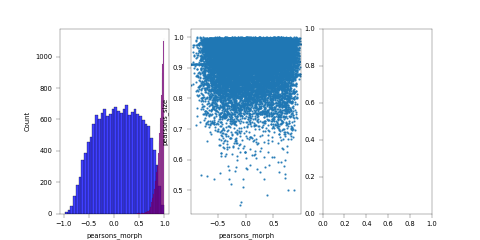

<AxesSubplot:xlabel='pearsons_morph', ylabel='pearsons_size'>

In [378]:
metric = 'pearsons'
fig, axn = pl.subplots(1,3, figsize=(6,3))
ax=axn[0]
sns.histplot(x='%s_morph' % metric, data=cc, ax=ax, color='blue')
sns.histplot(x='%s_size' % metric, data=cc, ax=ax, color='purple')

ax=axn[1]
sns.regplot(x='%s_morph' % metric,y='%s_size' % metric, data=cc, ax=ax,
           scatter_kws={'s':1})

In [391]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [470]:
rdf['experiment'] = 'blobs'
posdf = cr.get_roi_pos_and_rfs(rdf, curr_rfs=curr_rfs, rfs_only=False, 
                   merge_cols=['visual_area', 'datakey', 'cell'])
print(posdf.shape)

(185, 7)


In [399]:
cc = cr.get_pw_curve_correlations(rdf, stimulus='blobs')   
cc.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609


In [409]:
diffs_ = cc.copy()
# adist = cr.get_pw_distance(diffs_, curr_rfs, xcoord='ml_pos', ycoord='ap_pos',
#                         label='cortical_distance')
adist = cr.get_pw_distance(diffs_, posdf, xcoord='x0', ycoord='y0',
                        label='rf_distance')
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,129.947597


In [410]:
cc.shape, adist.shape

((17020, 9), (17020, 11))

<IPython.core.display.Javascript object>


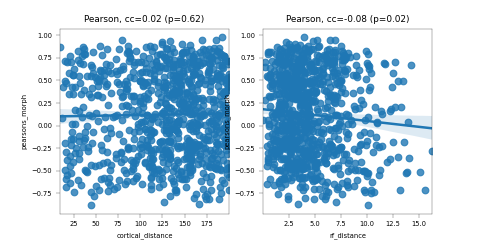

Text(0.5, 1.0, 'Pearson, cc=-0.08 (p=0.02)')

In [444]:
metric='pearsons'
y_var = '%s_morph' % metric
x_var = 'cortical_distance'
plotd=adist[adist.cortical_distance<200].copy()
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.regplot(x=x_var, y=y_var, data=plotd, ax=ax)
r, p = spstats.pearsonr(plotd[x_var], plotd[y_var])
ax.set_title('Pearson, cc=%.2f (p=%.2f)' % (r, p))

x_var = 'rf_distance'
ax=axn[1]
sns.regplot(x=x_var, y=y_var, data=plotd, ax=ax)
r, p = spstats.pearsonr(plotd[x_var], plotd[y_var])
ax.set_title('Pearson, cc=%.2f (p=%.2f)' % (r, p))


In [429]:
import copy

In [440]:
df = adist.copy()
# Split distances into X um bins
ctx_step=25
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


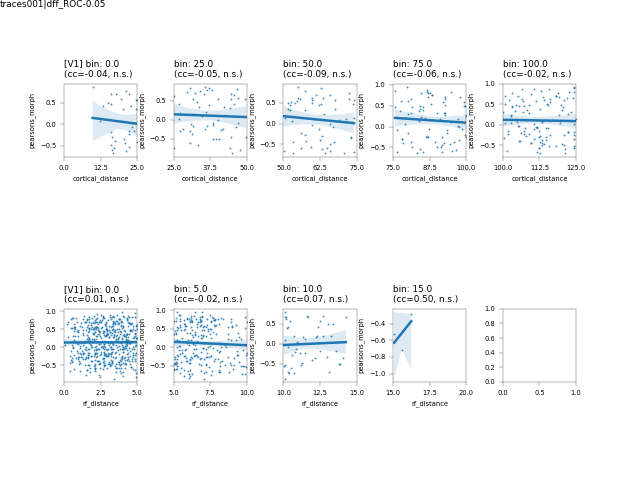

In [445]:
%matplotlib notebook

vg=df[(df.cortical_distance<200) ].copy()


y_var='pearsons_morph'

scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(2, n_bins_plot, figsize=(8,6))

dist_var = 'cortical_distance'
for ri, dist_var in enumerate(['cortical_distance', 'rf_distance']):
    dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[ri, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %.1f\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)


# Aggregate

In [528]:
response_type='dff'
do_spherical_correction=False
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [492]:
# va='V1'
# dk='20190616_JC097_fov1'
offset_type='minsub' 
lcorrection='exclude'
with_lum = False

rdf_list=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    if with_lum:
        configs = sdf.index.tolist()
    else:
        configs = sdf[sdf['morphlevel']!=-1].index.tolist()
    sizes = list(sorted(sdf['size'].unique()))
    morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
    # print(morphlevels)

    x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
              & (NDATA0.config.isin(configs))].copy()
    rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
             .mean().reset_index().drop('trial', axis=1)
    rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
    rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
    rdf['size'] = sdf.loc[rdf['config']]['size'].values
    rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values

    rdf_list.append(rdf)
avg_responses = pd.concat(rdf_list, axis=0, ignore_index=True)
avg_responses['experiment'] = 'blobs'

In [501]:
has_rfs = pd.concat([g for (va, dk), g in rfdf.groupby(['visual_area', 'datakey'])
                    if not avg_responses.query('@va==visual_area')])

,visual_area,datakey,cell,config,response,size,morphlevel,experiment
0,Li,20190315_JC070_fov1,145,config006,0.045293,10.0,0,blobs
1,Li,20190315_JC070_fov1,145,config007,0.034502,20.0,0,blobs
2,Li,20190315_JC070_fov1,145,config008,0.029531,30.0,0,blobs
3,Li,20190315_JC070_fov1,145,config009,0.040361,40.0,0,blobs
4,Li,20190315_JC070_fov1,145,config010,0.030793,50.0,0,blobs


In [527]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [529]:

DISTS = cr.aggregate_tuning_curve_ccdist(avg_responses, rfdf=rfdf, 
                                         min_ncells=5, stimulus='blobs')

too few cells: Li, 20190319_JC067_fov1
too few cells: Li, 20190320_JC067_fov1
too few cells: Li, 20190321_JC070_fov1
too few cells: Lm, 20191111_JC120_fov1
[]


In [531]:
DISTS.groupby('visual_area').count()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,,,,
Li,10770,10770,10770,10770,10770,10770,10770,10770,10770,1940,1940,1940,10770,10770,10770
Lm,28864,28864,28864,28864,28864,28864,28864,28864,28864,2463,2463,2463,28864,28864,28864
V1,74551,74551,74551,74551,74551,74551,74551,74551,74551,18307,18307,18307,74551,74551,74551


In [532]:
va='V1'
dk='20190616_JC097_fov1'
test_a = DISTS[(DISTS.visual_area==va) & (DISTS.datakey==dk)].copy()
test_a.shape, adist.shape

((17020, 16), (17020, 13))

In [533]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


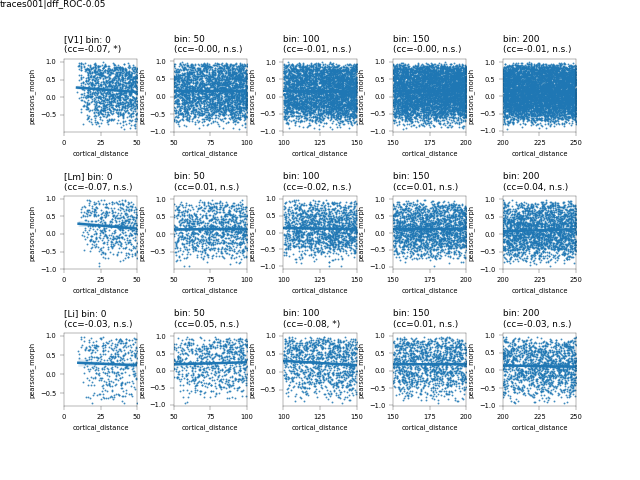

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning pearsons_morph_v_binCTX_50um


In [585]:
%matplotlib notebook
y_var='pearsons_morph'
dist_var = 'cortical_distance'
# -------------------------------------------------------------
dist_str='VF' if dist_var=='rf_distance' else 'CTX'
dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
dist_step = rf_step if dist_var=='rf_distance' else ctx_step
dist_unit = 'deg' if dist_var=='rf_distance' else 'um'
#
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,6))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_bin%s_%i%s' % (y_var, dist_str, dist_step, dist_unit)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [591]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


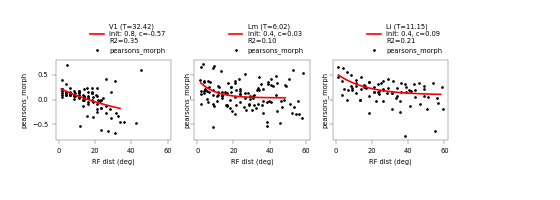

In [597]:
%matplotlib notebook
metric='pearsons_morph'
to_quartile = 'rf_distance'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)

xlabel='cortical dist (um)' if to_quartile=='cortical_distance' else 'RF dist (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index().dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
       #ax.set_title(va)
    #ax.set_xlim([0, 250])
   # ax.set_xlim([0, 40])
    #ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [559]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning'

In [516]:
va='V1'
dk='20190616_JC097_fov1'
df_ = avg_responses[(avg_responses.visual_area==va) & (avg_responses.datakey==dk)]

In [519]:

posdf_ = aggr.add_roi_positions(df_)
if rfdf is not None:
    posdf0 = posdf_.copy()
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf_ = cr.get_roi_pos_and_rfs(posdf0, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if posdf_.shape[0]==0:
        print(va, dk)

In [520]:
posdf_

,visual_area,datakey,cell,ml_pos,ap_pos,x0,y0
0,V1,20190616_JC097_fov1,0,909.977299,1078.506458,34.263130,-10.628686
1,V1,20190616_JC097_fov1,1,864.288063,1099.246967,NaN,NaN
2,V1,20190616_JC097_fov1,2,852.865753,1073.897456,30.848143,-6.732552
3,V1,20190616_JC097_fov1,9,873.806654,1023.198434,39.429009,-3.330024
4,V1,20190616_JC097_fov1,11,883.325245,993.239922,35.470047,-12.506376
...,...,...,...,...,...,...,...
180,V1,20190616_JC097_fov1,424,207.505284,1048.547945,29.780096,-2.802732
181,V1,20190616_JC097_fov1,425,32.363209,772.007828,20.431419,-7.071060
182,V1,20190616_JC097_fov1,426,45.689237,811.184344,NaN,NaN
183,V1,20190616_JC097_fov1,429,138.971429,520.817221,20.485330,-13.131780


In [524]:

cc = cr.get_pw_curve_correlations(df_, stimulus='blobs')
diffs_ = cc.copy()

if 'x0' in posdf_.columns:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)


In [526]:
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN,NaN,50.176439
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,35.873821,31.574280,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,39.569379,35.873821,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,37.610287,35.873821,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,40.524749,35.873821,129.947597


In [486]:
no_rfs=[]

curr_rfs=None
if rfdf is not None:
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf = cr.get_roi_pos_and_rfs(df_, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if curr_rfs.shape[0]==0:
        no_rfs.append((va, dk, exp))
else:
    posdf = aggr.add_roi_positions(df_)
no_rfs

[]

In [490]:
posdf_ = aggr.add_roi_positions(df_)
posdf_

,visual_area,datakey,cell,config,response,size,morphlevel,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,V1,20190616_JC097_fov1,0,config006,0.073549,10.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
1,V1,20190616_JC097_fov1,0,config007,0.062874,20.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
2,V1,20190616_JC097_fov1,0,config008,0.089596,30.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
3,V1,20190616_JC097_fov1,0,config009,0.102889,40.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
4,V1,20190616_JC097_fov1,0,config010,0.181599,50.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,V1,20190616_JC097_fov1,431,config046,0.047672,10.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8321,V1,20190616_JC097_fov1,431,config047,0.014780,20.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8322,V1,20190616_JC097_fov1,431,config048,0.016424,30.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8323,V1,20190616_JC097_fov1,431,config049,0.016479,40.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890


In [ ]:

cc = get_pw_curve_correlations(df_, n_intervals=n_intervals, stimulus=stimulus)
diffs_ = cc.copy()

# # Cortical and RF difff
# if 'ml_pos' not in df_.columns:
#     if stimulus=='blobs':
#         posdf0 = df_[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
#     else:
#         posdf0 = df_.copy()
#     posdf_ = aggr.add_roi_positionsS(posdf0)
# else:
#     posdf_ = df_.copy()        

if 'x0' in posdf_.columns:
    adist = get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)

assert adist.shape[0]==cc.shape[0], 'Bad merging: %s, %s' (va, dk)